# Übungsblatt 10
## Präsenzaufgaben
### Aufgabe 1 &nbsp;&nbsp;&nbsp; Herunterladen von Ressourcen
Laden Sie sich zunächst die Ressource `corpora/treebank` über den NLTK Download-Manager herunter.

In [1]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Aufgabe 2 &nbsp;&nbsp;&nbsp; Von Daten zu Regelwahrscheinlichkeiten
Gegeben sei folgende kontextfreie Grammatik:

In [2]:
cfg = """
S -> NP VP
VP -> V NP PP
VP -> V NP
NP -> DET N
NP -> NP PP
PP -> P NP

DET -> "the" | "a"
N -> "boy" | "woman" | "telescope"
V -> "saw"
P -> "with"
"""

Sie modelliert sehr einfache Sätze der Form `SBJ` *saw* `OBJ` mit optionaler Präpositionalphrase am Ende. Diese Präpositionalphrase kann entweder der näheren Bestimmung des Objekts oder der näheren Bestimmung der in der Verbalphrase ausgedrückten Handlung dienen.

Im folgenden sollen aus der Penn Treebank Wahrscheinlichkeiten für die einzelnen Regeln extrahiert werden, um dieser Ambiguität Herr zu werden.

#### (a) Relevante Konstruktionen erkennen
Nutzen das im NLTK enthaltene Sample der Penn Treebank (nach Installation unter `nltk.corpus.treebank` zu finden) zunächst zur Identifikation der für eine Disambiguierung nützlichen (Teil-)bäume der Penn Treebank.

*Hinweis:* Sie können sich bei der Analyse auf die jeweils 30 häufigsten Konstruktionen der Baumbank beschränken.

In [3]:
from collections import defaultdict
from nltk.corpus import treebank

def find_relevant_constructions(lhs, only_with=None):
    lhs_nt = nltk.grammar.Nonterminal(lhs)
    should_filter = only_with is not None
    if should_filter:
        filter_by = list(map(nltk.grammar.Nonterminal, only_with))
        def passes_filter(tup):
            for f in filter_by:
                if f not in tup:
                    return False
            return True

    counter = defaultdict(int)
    ### TODO: zähle Produktionen in treebank mit lhs als linker Seite ###
    ### und einer rechten Seite, für die passes_filter True liefert ###

    return [ (k, counter[k]) for k in sorted(counter.keys(), key=counter.__getitem__) ]

Die folgende Code-Zelle sollte mehrmals mit unterschiedlichen Parametern für `find_relevant_constructions` ausgeführt werden. Verschaffen Sie sich so interaktiv die nötigen Informationen zur Lösung der Aufgabe!

In [4]:
constructions = find_relevant_constructions('VP', only_with=["NP"])
constructions[-30:]

[]

Zählen Sie nun, wie oft die jeweiligen Konstruktionen in der Penn Treebank vorkommen und berechnen Sie die relativen Häufigkeiten als Approximation der Regelwahrscheinlichkeiten. Das Vorgehen wird in folgender Formel veranschaulicht:

$$P(V, N\!P, P\!P \mid V\!P) = \dfrac{count(V\!P \rightarrow V\:N\!P\:P\!P)}{count(V\!P \rightarrow \setminus*)}$$

In [5]:
vp_with_pp_frq = 1
vp_without_frq = 1
vp_with_pp = vp_with_pp_frq / (vp_with_pp_frq + vp_without_frq)
vp_without = vp_without_frq / (vp_with_pp_frq + vp_without_frq)

np_with_pp_frq = 1
np_without_frq = 1
np_with_pp = np_with_pp_frq / (np_with_pp_frq + np_without_frq)
np_without = np_without_frq / (np_with_pp_frq + np_without_frq)

det_the_frq = 1
det_a_frq = 1
det_the = det_the_frq / (det_the_frq + det_a_frq)
det_a = det_a_frq / (det_the_frq + det_a_frq)

(vp_with_pp, vp_without, np_with_pp, np_without, det_the, det_a)

(0.5, 0.5, 0.5, 0.5, 0.5, 0.5)

#### (b) Erstellen einer PCFG
Die aus den Daten extrahierten relativen Häufigkeiten sollen nun zur Erstellung einer probabilistischen kontextfreien Grammatik (PCFG)  genutzt werden.

In [6]:
pcfg = """
S -> NP VP     [1.0]
VP -> V NP PP  [{}]
VP -> V NP     [{}]
NP -> DET N    [{}]
NP -> NP PP    [{}]
PP -> P NP     [1.0]

DET -> "the"     [{}]
DET -> "a"       [{}]
N -> "boy"       [0.4]
N -> "woman"     [0.4]
N -> "telescope" [0.2]
V -> "saw"       [1.0]
P -> "with"      [1.0]
""".format(
    vp_with_pp, vp_without, np_without,
    np_with_pp, det_the, det_a
)
grammar = nltk.PCFG.fromstring(pcfg)
print(grammar)

Grammar with 13 productions (start state = S)
    S -> NP VP [1.0]
    VP -> V NP PP [0.5]
    VP -> V NP [0.5]
    NP -> DET N [0.5]
    NP -> NP PP [0.5]
    PP -> P NP [1.0]
    DET -> 'the' [0.5]
    DET -> 'a' [0.5]
    N -> 'boy' [0.4]
    N -> 'woman' [0.4]
    N -> 'telescope' [0.2]
    V -> 'saw' [1.0]
    P -> 'with' [1.0]


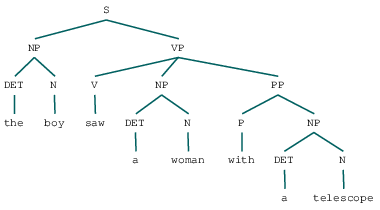

In [7]:
from IPython.display import display

parser = nltk.ViterbiParser(grammar)
for tree in parser.parse("the boy saw a woman with a telescope".split()):
    display(tree)

Wenn Sie sich die extrahierten Wahrscheinlichkeiten und das disambiguierte Ergebnis ansehen, überrascht Sie dann das Ergebnis der Syntaxanalyse?

### Aufgabe 3 &nbsp;&nbsp;&nbsp; Weiterverarbeitung syntaktischer Analysen
In dieser Aufgabe sollen Sie die Ausgaben eines state-of-the-art-Parsers, nämlich des Stanford Parsers, weiterverarbeiten.

Mit dem Ziel, Sie erst einmal mit den typischen Strukturen einer solchen Aufgabe vertraut zu machen, sollen Sie in dieser Aufgabe lediglich entscheiden, ob die Eingabe einen Infinitivsatz mit Objekt enthält.

Zur Klarheit betrachten Sie die folgenden positiven und negativen Beispiele:

In [8]:
pos_examples = [
    "Er beabsichtigt , den Kuchen ganz alleine zu essen .",
    "Er behauptet , ihn gesehen zu haben ."
]
neg_examples = [
    "Er glaubt , nach Hause zu fliegen .",
    "Zu fliegen ist schön .",
    "Er will gehen ."
]

Zur Erinnerung die wichtigsten Schritte zur Nutzung des Stanford Parsers im NLTK:

    1. Initialisierung

(Beachten Sie, dass der Pfad-Separator OS-spezifisch ist. Für UNIX ist unten / und für Windows \ zu verwenden.)

In [9]:
from nltk.parse.stanford import StanfordParser

PATH_TO_CORE = r"/pfad/zu/ihrem/CoreNLP/download"
PATH_TO_GERMAN_MODEL = r"/pfad/zu/dem/deutschen/modell"
jar = PATH_TO_CORE + '/' + "stanford-corenlp-3.8.0.jar"
model = PATH_TO_GERMAN_MODEL + '/' + "stanford-german-corenlp-2017-06-09-models.jar"

    2. Parser-Erstellung

In [10]:
parser = StanfordParser(
    jar, model,
    model_path="edu/stanford/nlp/models/lexparser/germanPCFG.ser.gz"
)

    3. Parsen

In [11]:
for sentence in pos_examples + neg_examples:
    tree_list = list(parser.raw_parse(sentence))
    tree_list[0].pretty_print(unicodelines=True)

                               ROOT                                      
                                │                                         
                                S                                        
 ┌────────┬────────┬────────────┴─────┬────────────────────────────────┐  
 │        │        │                  VP                               │ 
 │        │        │       ┌──────────┴────┬─────────────────┐         │  
 │        │        │       NP             AVP                VZ        │ 
 │        │        │   ┌───┴────┐     ┌────┴─────┐      ┌────┴────┐    │  
PPER    VVFIN      $, ART       NN   ADV        ADV   PTKZU     VVINF  $.
 │        │        │   │        │     │          │      │         │    │  
 Er  beabsichtigt  ,  den     Kuchen ganz     alleine   zu      essen  . 

                   ROOT                                    
                    │                                       
                    S                                      

Betrachten Sie die Ausgabe für die Beispielsätze. Schreiben Sie dann eine Funktion, die `True` zurückgibt, wenn ein Satz mit einem Infinitv, der ein Objekt hat, vorliegt und `False` sonst.

In [12]:
def classify(sentence):
    return False

Die Ausgabe sollte sein:

`True
True
False
False
False`

In [13]:
for p in pos_examples:
    print(classify(p))
for n in neg_examples:
    print(classify(n))

False
False
False
False
False
